In [1]:
#|default_exp sgd

# Accelerated SGD

In [1]:
#|export
import torch

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *

In [2]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from tinyai.datasets import *
from tinyai.conv import *
from tinyai.learner import *
from tinyai.activations import *
from tinyai.init import *

In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
# xl - > x label
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
# WHy those values.
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
activation_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
init_weights = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

### SGD

In [6]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)  # Regresion step
                self.opt_step(p)  # Optimization step
        self.i +=1  # later used for adam

    def opt_step(self, p): p -= p.grad * self.lr # update the params
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd  # update the params by weight_decay

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()  # function to zero the gradients

In [7]:
set_seed(42)
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.769,0.647,0,train
0.824,0.496,0,eval
0.843,0.430,1,train
0.840,0.442,1,eval
0.862,0.380,2,train
0.857,0.400,2,eval


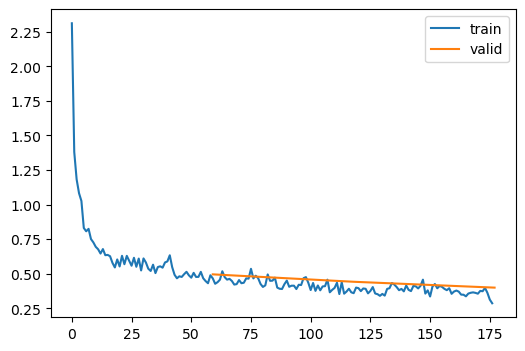

In [8]:
learn.fit(3)

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr*wd*weight
```

...vs...

``` python
weight.grad += wd*weight
```

### Momentum

In [9]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

Momentum allows us to see how the data changes without rapid `bumps/spikes`.

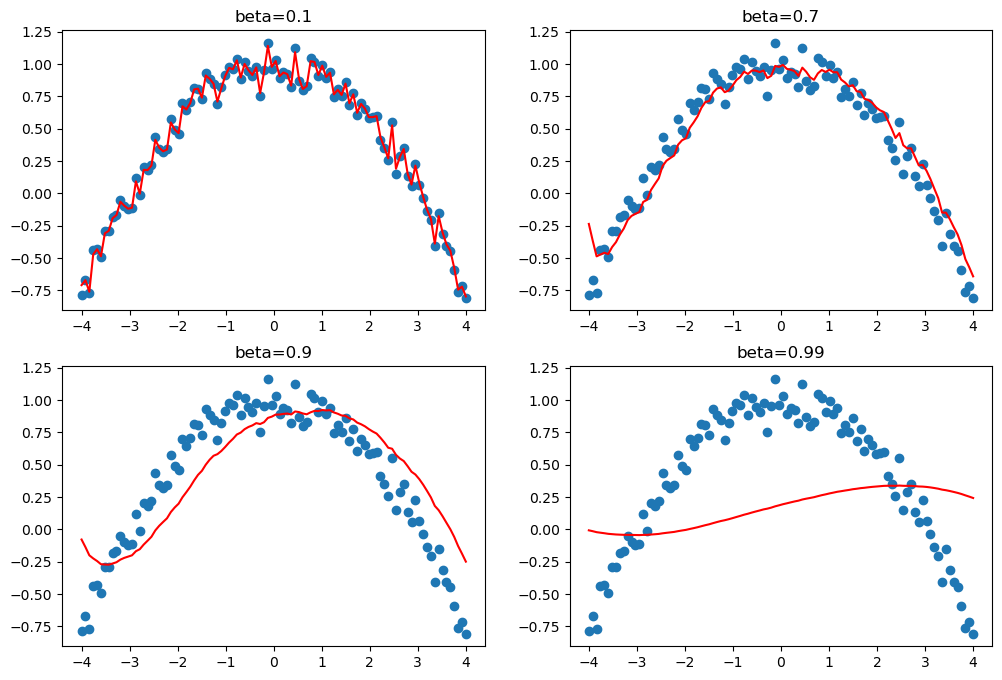

In [17]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.1,0.7,0.90,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [26]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)  
        self.mom = mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)  # set gradient avg at zeros at the start
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

It allows us to push our learning rate up to 1.5

In [27]:
set_seed(42)
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.788,0.586,0,train
0.847,0.422,0,eval
0.866,0.368,1,train
0.865,0.378,1,eval
0.883,0.320,2,train
0.872,0.352,2,eval


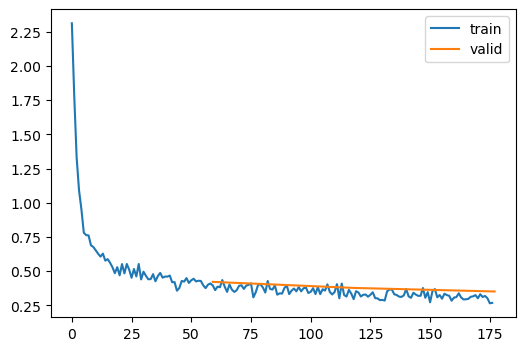

In [28]:
learn.fit(3)

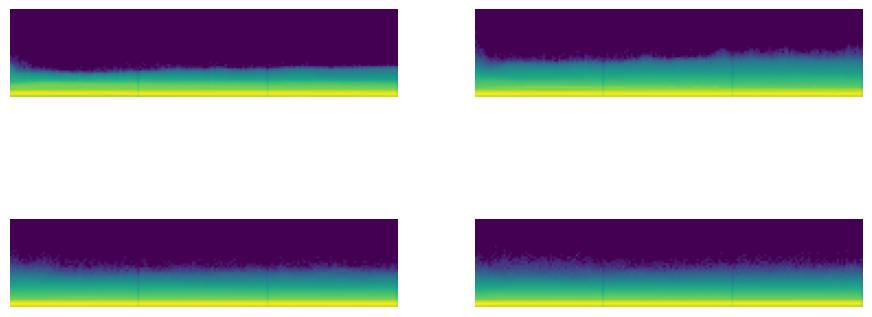

In [29]:
astats.color_dim()

### RMSProp

In [30]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)

$$ p_{avg} = p_{avg} * mom + p_{grad}^2 * (1- mom) $$
$$ p  -{=} lr * p_{grad} / \sqrt{p_{avg}} + eps  $$

accuracy,loss,epoch,train
0.769,0.659,0,train
0.827,0.481,0,eval
0.849,0.418,1,train
0.839,0.450,1,eval
0.864,0.372,2,train
0.857,0.399,2,eval


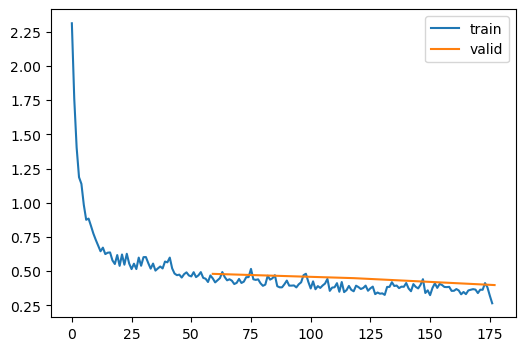

In [32]:
set_seed(42)
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

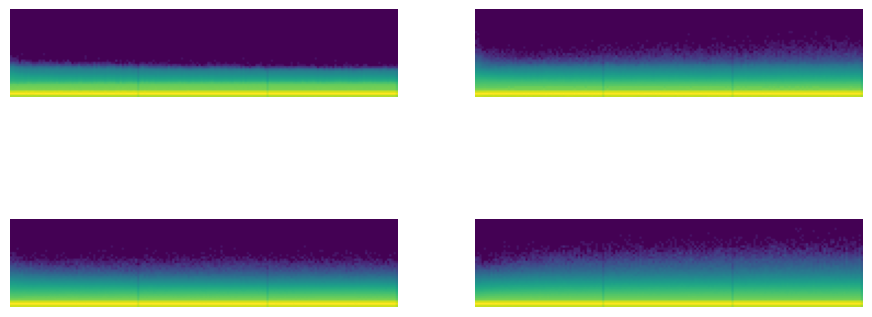

In [33]:
astats.color_dim()

In [42]:
Momentum.opt_step??

Signature: Momentum.opt_step(self, p)
Docstring: <no docstring>
Source:   
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'):
            p.grad_avg = torch.zeros_like(p.grad)  # set gradient avg at zeros at the start
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg
File:      /tmp/ipykernel_45349/8291813.py
Type:      function

In [43]:
RMSProp.opt_step??

Signature: RMSProp.opt_step(self, p)
Docstring: <no docstring>
Source:   
    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps)
File:      /tmp/ipykernel_45349/3229314230.py
Type:      function

### Adam

Adam is a combination of Momentum and RMSProp

In [47]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data) # MOM part
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data) # RMS part
        # Momentum p.grad_avg part
        p.avg = p.avg * self.beta1 + p.grad * (1-self.beta1)
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1))) # avg / (1 - 0.90**n)
        # RMSProp p.sqr_avg part
        p.sqr_avg = p.sqr_avg * self.beta2 + (p.grad**2) * (1-self.beta2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1))) # sqr_avg / (1 - 0.99**n)
        # combined parts
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.796,0.574,0,train
0.843,0.433,0,eval
0.868,0.363,1,train
0.866,0.372,1,eval
0.884,0.317,2,train
0.875,0.349,2,eval


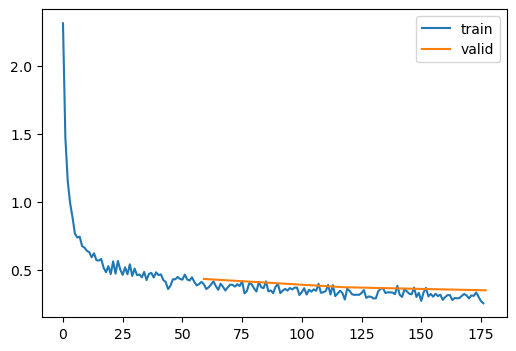

In [48]:
set_seed(42)
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

In [171]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [172]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer PolynomialLR ReduceLROnPlateau SequentialLR StepLR'

In [207]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [208]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'OptimizerPostHook OptimizerPreHook add_param_group defaults load_state_dict param_groups profile_hook_step register_load_state_dict_post_hook register_load_state_dict_pre_hook register_state_dict_post_hook register_state_dict_pre_hook register_step_post_hook register_step_pre_hook state state_dict step zero_grad'

In [209]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [210]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [211]:
st

{'momentum_buffer': None}

In [212]:
len(opt.param_groups)

1

In [213]:
pg = opt.param_groups[0]

In [214]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [215]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [216]:
' '.join(o for o in dir(sched) if o[0]!='_')

'T_max base_lrs eta_min get_last_lr get_lr last_epoch load_state_dict optimizer print_lr state_dict step verbose'

In [217]:
sched.base_lrs

[0.006]

In [218]:
sched.get_last_lr()

[0.006]

In [219]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

```python
sched = lr_scheduler.CosineAnnealingLR(opt, 100)
```
We did parse only 100 steps, after 100th step the function will raise up as cosine function does

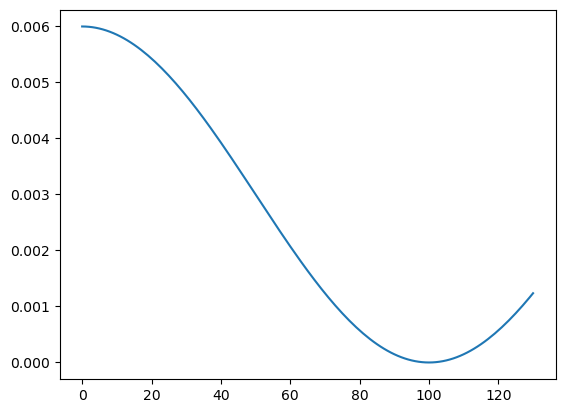

In [220]:
sched_lrs(sched, 130)

### Scheduler callbacks

In [127]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [128]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [129]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [130]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [131]:
def _lr(cb): return cb.pg['lr']

In [132]:
len(dls.train)

59

In [133]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.796,0.552,0,train
0.854,0.401,0,eval
0.875,0.344,1,train
0.865,0.359,1,eval
0.890,0.301,2,train
0.875,0.341,2,eval


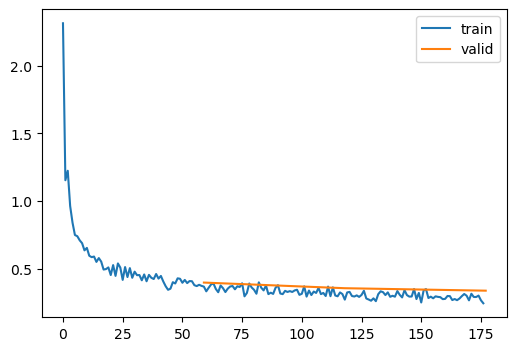

In [135]:
set_seed(42)
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
record = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

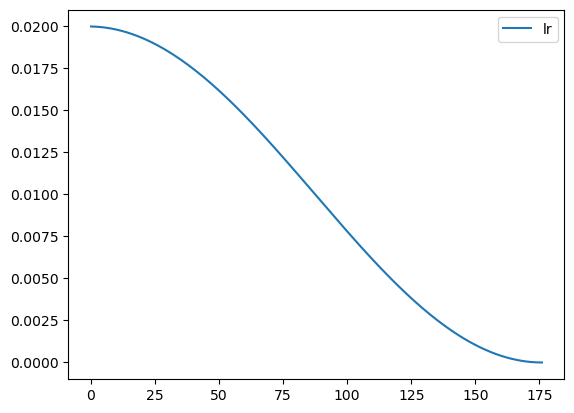

In [138]:
record.plot()

In [139]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

We change `BatchSchedCB` to `EpochSchedCB` which will change our recordings

accuracy,loss,epoch,train
0.796,0.552,0,train
0.849,0.419,0,eval
0.873,0.347,1,train
0.871,0.355,1,eval
0.893,0.293,2,train
0.878,0.329,2,eval


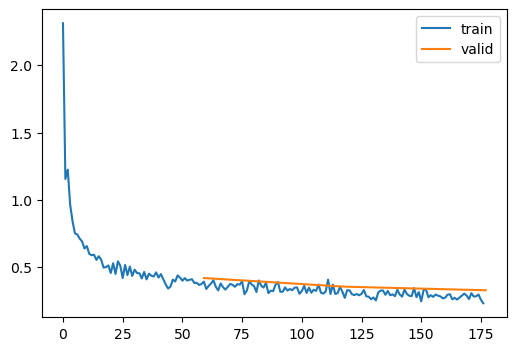

In [141]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),record]
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

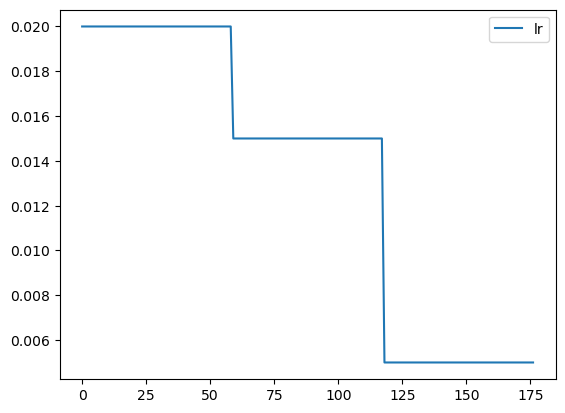

In [143]:
record.plot()

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

In [222]:
def _beta1(cb): return cb.pg['betas'][0]

record = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.771,0.648,0,train
0.826,0.506,0,eval
0.859,0.384,1,train
0.869,0.369,1,eval
0.885,0.311,2,train
0.877,0.345,2,eval
0.906,0.256,3,train
0.893,0.295,3,eval
0.919,0.221,4,train
0.900,0.279,4,eval


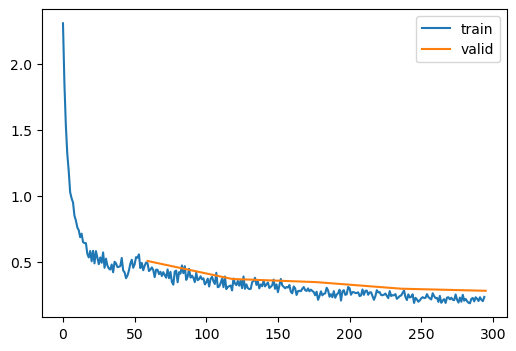

In [223]:
set_seed(42)
lr, epochs = 6e-2, 5
model = get_model(activation_gr, norm=nn.BatchNorm2d).apply(init_weights)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), record]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

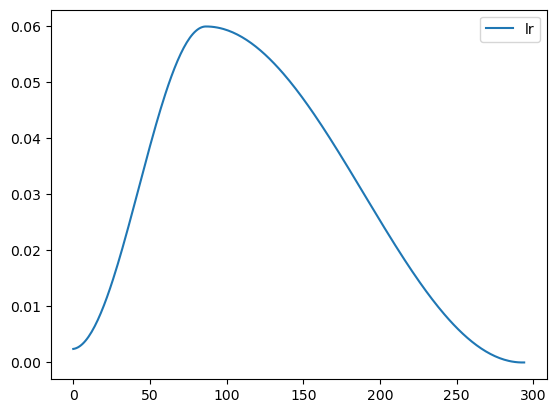

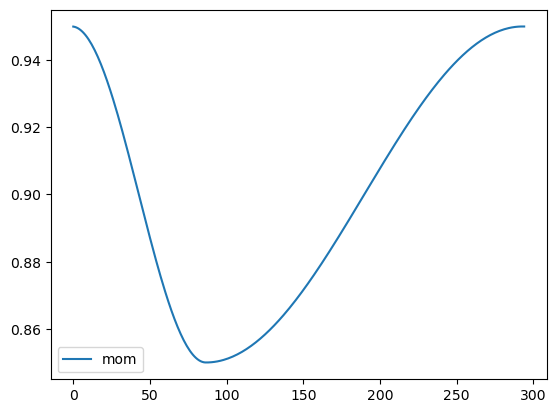

In [224]:
record.plot()

## Export -

In [225]:
import nbdev; nbdev.nbdev_export()